In [1]:
import sys
sys.path.insert(0, "../..")

import numpy as np
import scipy.signal
from matplotlib import pyplot as plt
plt.style.use('seaborn')

from module.base.network import Network
from module.simulation.meanfield import MeanField
from module.simulation.quick_meanfield2 import QuickMeanField2
import module.components.CONST as CONST
def set_size(width = "thesis", fraction=1, subplots=(1, 1)):
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    golden_ratio = (5**0.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

/tmp/ipykernel_421/1067228103.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
def fft(signal):
    n_0 = int(signal.shape[-1] / 2)
    signal_fft = np.fft.fft(signal)
    freq = np.fft.fftfreq(signal.shape[-1]) / dt * 2 * np.pi

    return freq[0:n_0], signal_fft[0:n_0]

def fft_amp(signal):
    n_0 = int(signal.shape[-1] / 2)
    signal_fft = np.fft.fft(signal)
    freq = np.fft.fftfreq(signal.shape[-1]) / dt * 2 * np.pi

    return freq[0:n_0], np.abs(signal_fft[0:n_0])

def fft_phase(signal):
    n_0 = int(signal.shape[-1] / 2)
    signal_fft = np.fft.fft(signal)
    freq = np.fft.fftfreq(signal.shape[-1]) / dt * 2 * np.pi

    return freq[0:n_0], np.angle(signal_fft[0:n_0])

In [3]:
net = Network(3,3,1,[[0,0,0],[2,0,0],[0,2,0],[2,2,0]])
dt = 0.008
t_max = 40
N = int(t_max / dt)

print("N =", N)
ts = np.linspace(0, t_max, N)        # nanoseconds
w1 = 20                              # omega
w2 = 70
U1 = np.sin(w1 * ts) * 0.1
U2 = np.sin(w2 * ts) * 0.1

N = 5000


In [4]:
mf = MeanField(net)
mf_means = np.zeros((N, 9))
mf_currents = np.zeros((N, 4))
means = np.zeros((9))
for i in range(N):
    net.set_voltage_config([0, U1[i], U2[i], 0], 0)
    means = mf.numeric_integration_solve(macrostate = means, N = 1, dt = dt)
    mf_means[i] = np.copy(means)

    mf_currents[i, 0] = mf.calc_expected_electrode_rates(means, 0) * CONST.electron_charge
    mf_currents[i, 1] = mf.calc_expected_electrode_rates(means, 1) * CONST.electron_charge
    mf_currents[i, 2] = mf.calc_expected_electrode_rates(means, 2) * CONST.electron_charge
    mf_currents[i, 3] = mf.calc_expected_electrode_rates(means, 3) * CONST.electron_charge

In [5]:
qmf2 = QuickMeanField2(net)
qmf2_means = np.zeros((N, 9))
qmf2_vars = np.zeros((N, 9))
qmf2_currents = np.zeros((N, 4))
for i in range(N):
    net.set_voltage_config([0, U1[i], U2[i], 0], 0)
    qmf2.numeric_integration_solve(N = 1, dt = dt, reset = False)
    qmf2_means[i] = np.copy(qmf2.means)
    qmf2_vars[i] = np.copy(qmf2.vars)

    qmf2_currents[i, 0] = qmf2.calc_expected_electrode_current(0)
    qmf2_currents[i, 1] = qmf2.calc_expected_electrode_current(1)
    qmf2_currents[i, 2] = qmf2.calc_expected_electrode_current(2)
    qmf2_currents[i, 3] = qmf2.calc_expected_electrode_current(3)

Text(0, 0.5, '$|\\widetilde f(\\omega)|^2$')

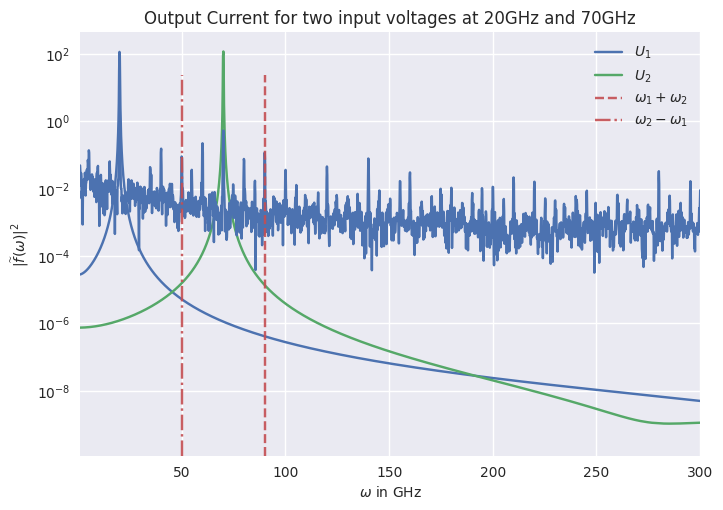

In [14]:
bm = scipy.signal.windows.hann(len(ts))

plt.plot(*fft_amp(U1 * bm), color = "C0", label = "$U_1$")
plt.plot(*fft_amp(U2* bm), color = "C1", label = "$U_2$")

plt.plot(*fft_amp(qmf2_currents[:, 0]* bm)) # is island 0.. electrodes at 1 and 2


# for i in range(1, 20):
#     plt.axvline(w1 * i, color = "C1", alpha = 0.5)
#     plt.axvline(w2 * i, color = "C2", alpha = 0.5)



plt.axvline(w1 + w2, alpha = 0.9, label = "$\\omega_1 + \\omega_2$", linestyle = "dashed", ymin = 0, ymax = 0.9, color = "C2")
plt.axvline(-w1 + w2, alpha = 0.9, label = "$\\omega_2 - \\omega_1$", linestyle = "dashdot", ymin = 0, ymax = 0.9, color = "C2")


plt.xlim(1, 300) 
plt.yscale("log")
plt.legend()
plt.title("Output Current for two input voltages at "+str(w1)+"GHz and "+str(w2)+"GHz")

plt.xlabel("$\\omega$ in GHz")
plt.ylabel("$|\widetilde f(\\omega)|^2$")

#plt.savefig("../../output/time_dependence/multiplication.pdf")